<a href="https://colab.research.google.com/github/HariCharan21903/Skin-cancer-detection-using-deep-learning/blob/main/skin_cancer_detection_usind_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import kagglehub
fanconic_skin_cancer_malignant_vs_benign_path = kagglehub.dataset_download('fanconic/skin-cancer-malignant-vs-benign')

print('Data source import complete.')


100%|██████████| 325M/325M [00:18<00:00, 18.7MB/s]

Extracting files...


Data source import complete.


In [ ]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
#from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization # Import BatchNormalization directly from keras.layers
from keras import backend as K
#from keras.layers.normalization import BatchNormalization # This line is removed
# 'to_categorical' has been moved to 'keras.utils'
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
# Import ImageDataGenerator from tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# Instead of importing KerasClassifier, define a function to create the Keras model
def create_model():
    # Define your Keras model here
    model = Sequential()
    # ... (add your model layers) ...
    return model


from keras.applications.resnet50 import ResNet50
from keras import backend as K

In [ ]:
import os
import kagglehub
from PIL import Image
import numpy as np

# Download the dataset using kagglehub
fanconic_skin_cancer_malignant_vs_benign_path = kagglehub.dataset_download('fanconic/skin-cancer-malignant-vs-benign')

# The downloaded data is already extracted, so no need to unzip

# Assuming the data is within the downloaded directory, update the paths
folder_benign_train = os.path.join(fanconic_skin_cancer_malignant_vs_benign_path, 'data/train/benign')
folder_malignant_train = os.path.join(fanconic_skin_cancer_malignant_vs_benign_path, 'data/train/malignant')

folder_benign_test = os.path.join(fanconic_skin_cancer_malignant_vs_benign_path, 'data/test/benign')
folder_malignant_test = os.path.join(fanconic_skin_cancer_malignant_vs_benign_path, 'data/test/malignant')

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# ... (rest of the code remains the same)

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

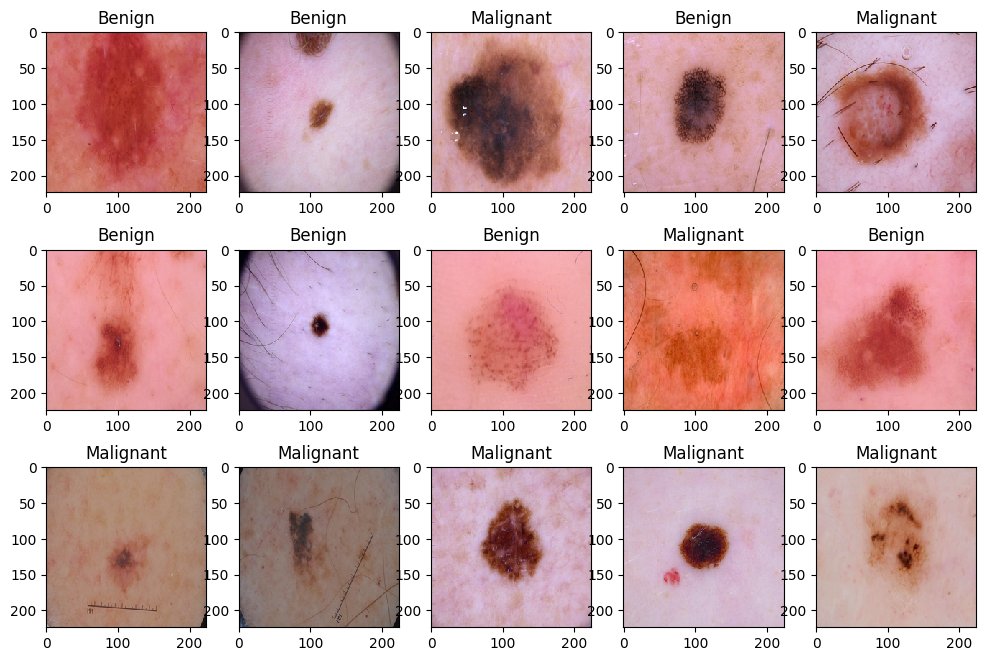

In [ ]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import numpy as np

# Load the pre-trained VGG16 model, excluding the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model that outputs the features from the VGG16 layers
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

# Display the architecture of the model (optional)
model.summary()

# Extract features from the training set
X_train_features = model.predict(X_train)

# Check the shape of the extracted features
print("Shape of extracted features:", X_train_features.shape)

# Flatten the features to be used as input for a fully connected layer in the final classification model
X_train_flattened = X_train_features.reshape(X_train_features.shape[0], -1)

# Display the shape of the flattened features
print("Shape of flattened features:", X_train_flattened.shape)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

83/83 ━━━━━━━━━━━━━━━━━━━━ 29s 191ms/step
Shape of extracted features: (2637, 7, 7, 512)
Shape of flattened features: (2637, 25088)


In [ ]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [ ]:
# With data augmentation to prevent overfitting
X_train = X_train/255.
X_test = X_test/255.

In [ ]:
# See learning curve and validation curve

def build(input_shape= (224,224,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-7)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,089 (98.15 MB)

 Trainable params: 25,729,089 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.4668 - loss: 24.5973 - val_accuracy: 0.5200 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 149ms/step - accuracy: 0.5279 - loss: 0.6928 - val_accuracy: 0.5150 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.5210 - loss: 0.6923 - val_accuracy: 0.5150 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.5069 - loss: 0.6925 - val_accuracy: 0.5150 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.5329 - loss: 0.6924 - val_accuracy: 0.5150 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5000 - loss: 0.6924
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5004 - loss: 0.6924 - v

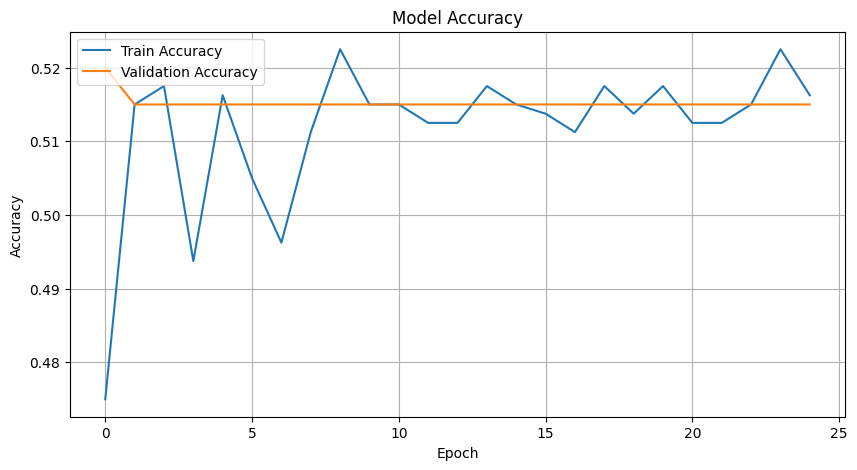

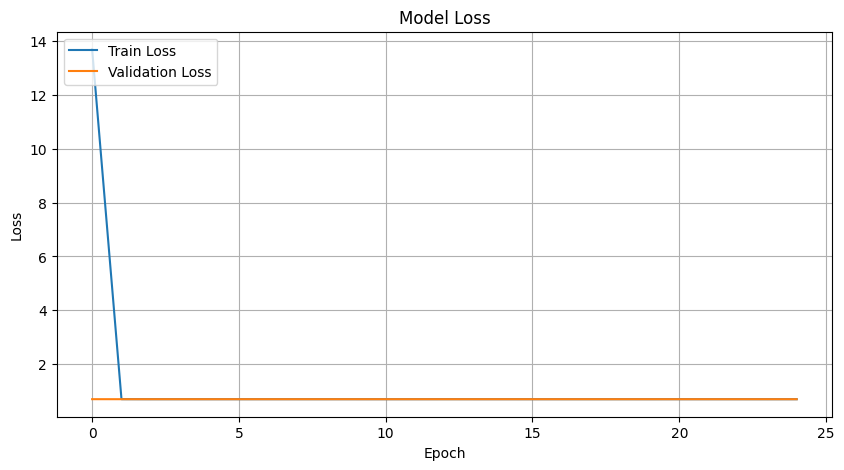

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
# Instead of keras.preprocessing.image, import from tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Dummy data for demonstration purposes
# In practice, replace this with your actual data loading code
# Example: Load your dataset, preprocess images, and create X and y
num_samples = 1000  # Adjust based on your dataset
image_size = (224, 224)  # Image size for the model input
X_data = np.random.rand(num_samples, 224, 224, 3)  # Replace with actual image data
y_data = np.random.randint(0, 2, num_samples)  # Replace with actual labels (0 or 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

def build(input_shape=(224, 224, 3), lr=1e-3, num_classes=2,
          init='normal', activ='relu', optim='adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', input_shape=input_shape,
                     activation=activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='Same',
                     activation=activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-7)

# Create and train the model
input_shape = (224, 224, 3)  # Adjust based on your image size
model = build(input_shape=input_shape)

# Fit the model and store the history
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=25, batch_size=64,
                    callbacks=[learning_rate_reduction])

# Plotting code remains unchanged...
# Ensure that 'history' contains training data
if 'accuracy' in history.history and 'val_accuracy' in history.history:
    # Plot model accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()
else:
    print("Accuracy data not found in history.")

# Ensure that 'loss' data is present
if 'loss' in history.history and 'val_loss' in history.history:
    # Plot model loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()
else:
    print("Loss data not found in history.")


In [ ]:
# Clear Keras session and delete the model to free up memory
from keras import backend as K

# Clear the session to remove any saved states in memory
K.clear_session()

# Delete the model object to free up memory
try:
    del model
except NameError:
    print("Model has already been deleted or not defined yet.")

# Make sure to only delete 'history' after you have completed all operations with it
try:
    del history
except NameError:
    print("History has already been deleted or not defined yet.")


In [ ]:
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau

# Define input shape for images
input_shape = (224, 224, 3)

# Example dataset (Replace with actual image data and labels)
X = np.random.rand(100, 224, 224, 3)  # Example: 100 samples of 224x224x3 images
y = np.random.randint(0, 2, 100)      # Example labels: 0 or 1 for 100 samples

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to build the CNN model
def build(input_shape=(224, 224, 3), lr=1e-3, num_classes=2,
          init='normal', activ='relu', optim='adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', input_shape=input_shape,
                     activation=activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='Same',
                     activation=activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))  # Softmax for multi-class classification
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr)  # Changed lr to learning_rate
    else:
        optimizer = Adam(learning_rate=lr)  # Changed lr to learning_rate

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Define 3-fold cross-validation test harness
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

# Hyperparameters
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50
batch_size = 64

cvscores = []

for train_index, test_index in kfold.split(X_train, y_train):
    # Create a new model for each fold to avoid state carryover
    model = build(lr=lr,
                  init=init,
                  activ=activ,
                  optim=optim,
                  input_shape=input_shape)

    # Fit the model on the training data of the current fold
    model.fit(X_train[train_index], y_train[train_index],
              epochs=epochs, batch_size=batch_size, verbose=1)

    # Evaluate the model on the test data of the current fold
    scores = model.evaluate(X_train[test_index], y_train[test_index], verbose=0)
    print(f"Fold accuracy: {scores[1] * 100:.2f}%")
    cvscores.append(scores[1] * 100)

# Display the cross-validation results
print(f"Cross-validation accuracy mean: {np.mean(cvscores):.2f}%")
print(f"Cross-validation accuracy standard deviation: {np.std(cvscores):.2f}%")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.4528 - loss: 2.3646
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5660 - loss: 1.5215
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.4528 - loss: 1.4488
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5283 - loss: 1.2476
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5094 - loss: 1.6089
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.4717 - loss: 1.6820
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.4528 - loss: 1.5624
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.4906 - loss: 1.9307
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.5094 - loss: 1.4579
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.4528 - loss: 1.3726
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5094 - loss: 1.2771
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.4528 - loss: 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5283 - loss: 3.9050
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.4528 - loss: 2.1510
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5472 - loss: 2.3003
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.4717 - loss: 1.9764
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.3962 - loss: 2.5934
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5472 - loss: 1.8275
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.4340 - loss: 2.9368
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4528 - loss: 2.4936
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.4717 - loss: 2.2685
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.4151 - loss: 2.0754
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4340 - loss: 3.0034
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.4717 - loss:

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.5000 - loss: 2.5441
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4074 - loss: 2.0826
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5370 - loss: 1.5999
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5370 - loss: 1.5245
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5556 - loss: 1.9533
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.4259 - loss: 1.6156
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.4444 - loss: 1.7644
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5926 - loss: 1.0853
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.4074 - loss: 1.9855
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.4815 - loss: 1.4204
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.3704 - loss: 2.2940
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5185 - loss: 

In [ ]:
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report


# Define input shape for images
input_shape = (224, 224, 3)

# Example dataset (Replace with actual image data and labels)
X = np.random.rand(100, 224, 224, 3)  # Example: 100 samples of 224x224x3 images
y = np.random.randint(0, 2, 100)      # Example labels: 0 or 1 for 100 samples

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to build the CNN model
def build(input_shape=(224, 224, 3), lr=1e-3, num_classes=2,
          init='normal', activ='relu', optim='adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', input_shape=input_shape,
                     activation=activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='Same',
                     activation=activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))  # Softmax for multi-class classification
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr)  # Changed lr to learning_rate
    else:
        optimizer = Adam(learning_rate=lr)  # Changed lr to learning_rate

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Define 3-fold cross-validation test harness
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

# Hyperparameters
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50
batch_size = 64

cvscores = []

for train_index, test_index in kfold.split(X_train, y_train):
    # Create a new model for each fold to avoid state carryover
    model = build(lr=lr,
                  init=init,
                  activ=activ,)

import numpy as np
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report


# Define input shape for images
input_shape = (224, 224, 3)

# Example dataset (Replace with actual image data and labels)
X = np.random.rand(100, 224, 224, 3)  # Example: 100 samples of 224x224x3 images
y = np.random.randint(0, 2, 100)      # Example labels: 0 or 1 for 100 samples

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to build the CNN model
def build(input_shape=(224, 224, 3), lr=1e-3, num_classes=2,
          init='normal', activ='relu', optim='adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', input_shape=input_shape,
                     activation=activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='Same',
                     activation=activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))  # Softmax for multi-class classification
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr)  # Changed lr to learning_rate
    else:
        optimizer = Adam(learning_rate=lr)  # Changed lr to learning_rate

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Define 3-fold cross-validation test harness
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

# Hyperparameters
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50
batch_size = 64

cvscores = []

for train_index, test_index in kfold.split(X_train, y_train):
    # Create a new model for each fold to avoid state carryover
    model = build(lr=lr,
                  init=init,
                  activ=activ,
                  optim=optim,
                  input_shape=input_shape)

    # Fit the model on the training data of the current fold
    model.fit(X_train[train_index], y_train[train_index], epochs=epochs, batch_size=batch_size, verbose=0)

    # Evaluate the model on the test data of the current fold
    scores = model.evaluate(X_train[test_index], y_train[test_index], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

# After the cross-validation, you can train a final model on the entire training set
# and evaluate it on the held-out test set:
model = build(lr=lr, init=init, activ=activ, optim=optim, input_shape=input_shape)
model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report


# Define input shape for images
input_shape = (224, 224, 3)

# Example dataset (Replace with actual image data and labels)
X = np.random.rand(100, 224, 224, 3)  # Example: 100 samples of 224x224x3 images
y = np.random.randint(0, 2, 100)      # Example labels: 0 or 1 for 100 samples

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to build the CNN model
def build(input_shape=(224, 224, 3), lr=1e-3, num_classes=2,
          init='normal', activ='relu', optim='adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', input_shape=input_shape,
                     activation=activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='Same',
                     activation=activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))  # Softmax for multi-class classification
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr)  # Changed lr to learning_rate
    else:
        optimizer = Adam(learning_rate=lr)  # Changed lr to learning_rate

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Define 3-fold cross-validation test harness
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

# Hyperparameters
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50
batch_size = 64

cvscores = []

for train_index, test_index in kfold.split(X_train, y_train):
    # Create a new model for each fold to avoid state carryover
    model = build(lr=lr,
                  init=init,
                  activ=activ,
                  optim=optim,
                  input_shape=input_shape)

    # Fit the model on the training data of the current fold
    model.fit(X_train[train_index], y_train[train_index], epochs=epochs, batch_size=batch_size, verbose=0)

    # Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Display the classification report for precision, recall, and F1 score
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Display the classification report for precision, recall, and F1 score
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

compile_metrics: 66.67%


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

compile_metrics: 66.67%


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

compile_metrics: 65.38%
66.24% (+/- 0.60%)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Confusion Matrix:
[[3 8]
 [3 6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.27      0.35        11
           1       0.43      0.67      0.52         9

    accuracy                           0.45        20
   macro avg       0.46      0.47      0.44        20
weighted avg       0.47      0.45      0.43        20

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Confusion Matrix:
[[3 8]
 [3 6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.27      0.35        11
           1       0.43      0.67      0.52         9

    accuracy                           0.45        20
   macro avg       0.46      0.47      0.44        20
weighted avg       0.47      0.45      0.43        20



In [ ]:
# Make sure all the required imports are present
import numpy as np
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical  # Import to_categorical
from keras.callbacks import ReduceLROnPlateau # Import ReduceLROnPlateau

# Define the number of epochs and batch size
epochs = 30  # You can adjust this number as required
batch_size = 32

# Define the input shape for the model
input_shape = (224, 224, 3)

# Build the model with appropriate parameters
model = build(lr=lr,
              init=init,
              activ=activ,
              optim=optim,
              input_shape=input_shape)

# One-hot encode the target variables
y_train = to_categorical(y_train, num_classes=2)  # Assuming 2 classes
y_test = to_categorical(y_test, num_classes=2)    # Assuming 2 classes


# Compile the model (ensure this step is done)
model.compile(optimizer=optim,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Instantiate the ReduceLROnPlateau callback
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',  # Monitor validation accuracy
                                            patience=3,            # Number of epochs with no improvement after which learning rate will be reduced
                                            verbose=1,            # Print messages when learning rate is reduced
                                            factor=0.5,           # Factor by which the learning rate will be reduced
                                            min_lr=0.00001)      # Lower bound on the learning rate

# Fit the model to the training data
model.fit(X_train, y_train,
          epochs=epochs,
          batch_size=batch_size,
          verbose=1,  # Change to 1 for a more detailed log output
          callbacks=[learning_rate_reduction]
         )

# Testing the model on test data to evaluate
y_pred = np.argmax(model.predict(X_test), axis=1)  # Use np.argmax to convert probabilities to class labels

# Evaluate the accuracy
print("Accuracy:", accuracy_score(np.argmax(y_test, axis=1), y_pred))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4930 - loss: 38.6360 - learning_rate: 0.0010
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4117 - loss: 4.0528 - learning_rate: 0.0010
Epoch 3/30


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4977 - loss: 1.0698 - learning_rate: 0.0010
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5773 - loss: 0.6883 - learning_rate: 0.0010
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4156 - loss: 0.6947 - learning_rate: 0.0010
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4500 - loss: 0.7007 - learning_rate: 0.0010
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4789 - loss: 0.6958 - learning_rate: 0.0010
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4125 - loss: 0.6990 - learning_rate: 0.0010
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4969 - loss: 0.6920 - learning_rate: 0.0010
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4984 - loss: 0.6901 - learning_rate: 0.0010
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5562 - loss: 0.6847 - learning_rate: 0.0010
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/s

In [ ]:
# save model
# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
# Change the filename to end with `.weights.h5`
model.save_weights("model.weights.h5")
print("Saved model to disk")

# Clear memory, because of memory overload
del model
# Import K from keras
from keras import backend as K
K.clear_session()

Saved model to disk


Epoch 1/50
1/1 - 91s - 91s/step - accuracy: 0.5312 - loss: 0.8502 - val_accuracy: 0.6250 - val_loss: 0.6909 - learning_rate: 1.0000e-05
Epoch 2/50
1/1 - 37s - 37s/step - accuracy: 1.0000 - loss: 0.4751 - val_accuracy: 0.6250 - val_loss: 0.6925 - learning_rate: 1.0000e-05
Epoch 3/50

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
1/1 - 1s - 1s/step - accuracy: 1.0000 - loss: 0.2829 - val_accuracy: 0.6250 - val_loss: 0.6926 - learning_rate: 1.0000e-05
Epoch 4/50
1/1 - 1s - 604ms/step - accuracy: 1.0000 - loss: 0.1796 - val_accuracy: 0.7500 - val_loss: 0.6928 - learning_rate: 5.0000e-06
Epoch 5/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
1/1 - 1s - 630ms/step - accuracy: 1.0000 - loss: 0.1453 - val_accuracy: 0.4375 - val_loss: 0.6933 - learning_rate: 5.0000e-06
Epoch 6/50
1/1 - 1s - 617ms/step - accuracy: 1.0000 - loss: 0.1182 - val_accuracy: 0.3750 - val_loss: 0.6935 - learning_rate: 2.5000e-06
Epoch 7/50

Epoch 7: ReduceLR

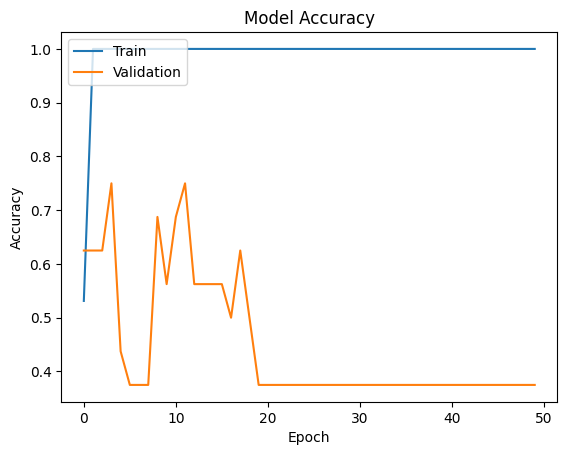

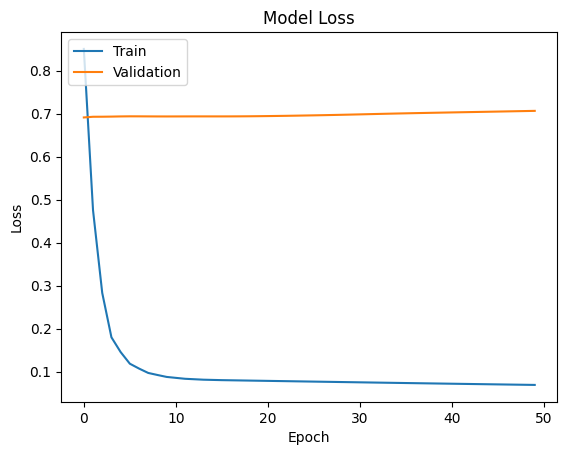

In [ ]:
# Import necessary libraries
from keras.applications import ResNet50
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define model parameters
input_shape = (224, 224, 3)
learning_rate = 1e-5
epochs = 50
batch_size = 64

# Define the model
model = ResNet50(include_top=True,
                 weights=None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Ensure that learning_rate_reduction callback is defined properly
# Example of learning rate reduction callback
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-7)

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs=epochs, batch_size=batch_size, verbose=2,
                    callbacks=[learning_rate_reduction])

# Plotting model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Train ResNet50 on all the data
model.fit(X_train, y_train,
          epochs=epochs, batch_size= epochs, verbose=0,
          callbacks=[learning_rate_reduction]
         )


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
